# NFL Game Win 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import datetime
#from kaggle.competitions import nflrush
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import os
import re
import keras
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.isotonic import IsotonicRegression
from keras.utils import Sequence
tqdm.pandas()

from numba import jit

Using TensorFlow backend.
C:\Users\Solomonzhs\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
import random as rn
import tensorflow as tf
import numpy as np
from keras import backend as K

def init_seeds(seed):

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are a potential source of
    # non-reproducible results.
    # For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res



    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed)

    sess = tf.Session(graph=tf.get_default_graph())
    K.set_session(sess)
    return sess

In [5]:
train = pd.read_csv(r"C:\Users\Solomonzhs\Desktop\Kaggle\nfl-rush\train.csv", dtype={'WindSpeed': 'object'})
train.shape
results = {}

In [6]:
player_cols = ['X', 'Y', 'X_dir', 'Y_dir', 'X_S', 'Y_S', 'S', 'A', 'IsRusher', 'IsOnOffense']
#player_cols = ['X', 'Y', 'X_dir', 'Y_dir', 'X_S', 'Y_S', 'S', 'A', 'Energy', 'IsRusher', 'IsOnOffense']
play_cols = ['X_rusher', 'Y_rusher', 'YardLine_std']

In [8]:
def reorient(train, flip_left):
    train['ToLeft'] = train.PlayDirection == "left"
    #train['IsBallCarrier'] = train.NflId == train.NflIdRusher
    
    train.loc[train.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
    train.loc[train.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"
    
    train.loc[train.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
    train.loc[train.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"
    
    train.loc[train.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
    train.loc[train.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"
    
    train.loc[train.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
    train.loc[train.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"
    
    train['TeamOnOffense'] = "home"
    train.loc[train.PossessionTeam != train.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    train['IsOnOffense'] = train.Team == train.TeamOnOffense # Is player on offense?
    train['YardLine_std'] = 100 - train.YardLine
    train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine_std'
         ] = train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine']
    train.loc[train.ToLeft, 'X'] = 120 - train.loc[train.ToLeft, 'X'] 
    train.loc[train.ToLeft, 'Y'] = 160/3 - train.loc[train.ToLeft, 'Y'] 
    train.loc[train.ToLeft, 'Orientation'] = np.mod(180 + train.loc[train.ToLeft, 'Orientation'], 360)
    train['Dir'] = 90 - train.Dir
    train.loc[train.ToLeft, 'Dir'] = np.mod(180 + train.loc[train.ToLeft, 'Dir'], 360)
    train.loc[train.IsOnOffense, 'Dir'] = train.loc[train.IsOnOffense, 'Dir'].fillna(0).values
    train.loc[~train.IsOnOffense, 'Dir'] = train.loc[~train.IsOnOffense, 'Dir'].fillna(180).values
    
    
    train['IsRusher'] = train['NflId'] == train['NflIdRusher']
    if flip_left:
        df = train[train['IsRusher']].copy()
        #df['left'] = df.Y < 160/6
        df['left'] = df.Dir < 0
        train = train.merge(df[['PlayId', 'left']], how='left', on='PlayId')
        train['Y'] = train.Y
        train.loc[train.left, 'Y'] = 160/3 - train.loc[train.left, 'Y']
        train['Dir'] = train.Dir
        train.loc[train.left, 'Dir'] = np.mod( - train.loc[train.left, 'Dir'], 360)
        train.drop('left', axis=1, inplace=True)
        
    
    train['X_dir'] = np.cos( (np.pi / 180) * train .Dir)
    train['Y_dir'] = np.sin( (np.pi / 180) * train.Dir)
    train['X_S'] = train.X_dir * train.S
    train['Y_S'] = train.Y_dir * train.S
    train['X_A'] = train.X_dir * train.A
    train['Y_A'] = train.Y_dir * train.A
    
    train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
    train['BMI'] = (train['PlayerWeight'] * 703) / (train['PlayerHeight'] ** 2)
    train['Energy'] = train['PlayerWeight'] * (train['S'] ** 2) 
    train.loc[train['Season'] == 2017, 'S'] = (train['S'][train['Season'] == 2017] - 2.4355) / 1.2930 * 1.4551 + 2.7570
    train['time_step'] = 0.0
    train = train.sort_values(by=['PlayId', 'IsOnOffense', 'IsRusher', 'Y']).reset_index(drop=True)
    return  train

In [9]:
def add_features(train):
        
    df = train[train.IsRusher][['PlayId', 'time_step', 'X', 'Y']].copy()
    df.columns = ['PlayId', 'time_step', 'X_rusher', 'Y_rusher']
    train = train.merge(df, how='left', on=['PlayId', 'time_step'])
    #train.loc[~train.IsRusher, 'X'] = train.loc[~train.IsRusher, 'X'] - train.loc[~train.IsRusher, 'X_rusher']
    #train.loc[~train.IsRusher, 'Y'] = train.loc[~train.IsRusher, 'Y'] - train.loc[~train.IsRusher, 'Y_rusher']
    train.X -= train.X_rusher
    train.Y -= train.Y_rusher
    
    #train.drop(['Orientation', 'Dir', 'TeamOnOffense', 'YardLine', 'left'], axis=1, inplace=True)
    return  train


In [10]:
def time_forward(train, time_step):
    train = train.copy()
    train['X'] = train['X'] + time_step * train['X_S'] + 0.5 * time_step**2 * train['X_A']
    train['Y'] = train['Y'] + time_step * train['Y_S'] + 0.5 * time_step**2 * train['Y_A']
    x_s = np.clip(train['X_S'] + time_step * train['X_A'], -14, 14)
    y_s = np.clip(train['Y_S'] + time_step * train['Y_A'], -14, 14)
    if 1:
        train['X_A'] = np.clip(train['X_A'] * train['X_S'] / (x_s), -10, 10)
        train['Y_A'] = np.clip(train['Y_A'] * train['Y_S'] / (y_s), -10, 10)
    train['X_S'] = x_s
    train['Y_S'] = y_s
    train['time_step'] = time_step
    return train

In [11]:
train_reorient = reorient(train.copy(), flip_left=True)
len_train_reorient = len(train_reorient) // 22

In [12]:
train_reorient

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,IsRusher,X_dir,Y_dir,X_S,Y_S,X_A,Y_A,BMI,Energy,time_step
0,2017090700,20170907000118,away,46.65,14.503333,5.136589,0.76,0.51,255.47,79.16,...,False,0.188067,0.982156,0.855705,4.468811,0.142931,0.746439,26.715085,4078.3925,0.0
1,2017090700,20170907000118,away,50.68,17.913333,2.064336,2.43,0.16,192.63,105.69,...,False,-0.270432,0.962739,-0.492187,1.752185,-0.657151,2.339456,27.935571,682.3544,0.0
2,2017090700,20170907000118,away,46.09,18.493333,1.918039,1.13,0.40,261.99,92.82,...,False,-0.049198,0.998789,-0.083145,1.687953,-0.055594,1.128632,28.749228,605.4932,0.0
3,2017090700,20170907000118,away,46.00,20.133333,1.389116,0.59,0.31,183.01,67.27,...,False,0.386389,0.922336,0.471395,1.125250,0.227970,0.544178,33.744000,401.8680,0.0
4,2017090700,20170907000118,away,45.33,20.693333,0.488822,1.35,0.01,207.61,71.30,...,False,0.320613,0.947210,0.134657,0.397828,0.432828,1.278734,35.993600,50.8032,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,2018123015,20181230154157,home,84.57,28.963333,4.360000,1.79,0.47,148.08,93.34,...,False,-0.058261,0.998301,-0.254018,4.352594,-0.104287,1.786959,36.975674,6083.0720,0.0
509758,2018123015,20181230154157,home,85.68,29.023333,1.040000,0.35,0.10,43.66,236.53,...,False,-0.551500,-0.834175,-0.573560,-0.867542,-0.193025,-0.291961,38.385135,323.3984,0.0
509759,2018123015,20181230154157,home,86.77,29.133333,2.140000,2.12,0.22,44.55,285.31,...,False,0.264041,-0.964511,0.565049,-2.064054,0.559768,-2.044764,30.158284,1195.2756,0.0
509760,2018123015,20181230154157,home,86.76,31.313333,2.580000,0.74,0.26,65.37,311.26,...,False,0.659477,-0.751725,1.701451,-1.939450,0.488013,-0.556276,30.427632,1664.1000,0.0


In [13]:
def augment_data(train_reorient, time_steps):
    train_reorient = pd.concat(time_forward(train_reorient, time_step) for time_step in time_steps)
    train_reorient = add_features(train_reorient)
    return train_reorient

In [14]:
time_steps = [0, 0.3, 0.6]
train_reorient = augment_data(train_reorient, time_steps)

In [15]:
train_reorient

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Y_dir,X_S,Y_S,X_A,Y_A,BMI,Energy,time_step,X_rusher,Y_rusher
0,2017090700,20170907000118,away,5.400000,-8.300000,5.136589,0.76,0.51,255.47,79.16,...,0.982156,0.855705,4.468811,0.142931,0.746439,26.715085,4078.3925,0.0,41.250000,22.803333
1,2017090700,20170907000118,away,9.430000,-4.890000,2.064336,2.43,0.16,192.63,105.69,...,0.962739,-0.492187,1.752185,-0.657151,2.339456,27.935571,682.3544,0.0,41.250000,22.803333
2,2017090700,20170907000118,away,4.840000,-4.310000,1.918039,1.13,0.40,261.99,92.82,...,0.998789,-0.083145,1.687953,-0.055594,1.128632,28.749228,605.4932,0.0,41.250000,22.803333
3,2017090700,20170907000118,away,4.750000,-2.670000,1.389116,0.59,0.31,183.01,67.27,...,0.922336,0.471395,1.125250,0.227970,0.544178,33.744000,401.8680,0.0,41.250000,22.803333
4,2017090700,20170907000118,away,4.080000,-2.110000,0.488822,1.35,0.01,207.61,71.30,...,0.947210,0.134657,0.397828,0.432828,1.278734,35.993600,50.8032,0.0,41.250000,22.803333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529281,2018123015,20181230154157,home,0.374455,3.181422,4.360000,1.79,0.47,148.08,93.34,...,0.998301,-0.316590,5.424770,-0.083675,1.433777,36.975674,6083.0720,0.6,84.024362,28.715121
1529282,2018123015,20181230154157,home,1.276757,-0.264865,1.040000,0.35,0.10,43.66,236.53,...,-0.834175,-0.689375,-1.042718,-0.160597,-0.242912,38.385135,323.3984,0.6,84.024362,28.715121
1529283,2018123015,20181230154157,home,3.185425,-1.188277,2.140000,2.12,0.22,44.55,285.31,...,-0.964511,0.900909,-3.290913,0.351085,-1.282472,30.158284,1195.2756,0.6,84.024362,28.715121
1529284,2018123015,20181230154157,home,3.844350,1.334413,2.580000,0.74,0.26,65.37,311.26,...,-0.751725,1.994259,-2.273216,0.416360,-0.474601,30.427632,1664.1000,0.6,84.024362,28.715121


In [16]:
df = train_reorient[player_cols]

In [17]:
df.shape

(1529286, 10)

In [21]:
df.head(n=22)

,X,Y,X_dir,Y_dir,X_S,Y_S,S,A,IsRusher,IsOnOffense
0,5.40,-8.30,0.188067,0.982156,0.855705,4.468811,5.136589,0.76,False,False
1,9.43,-4.89,-0.270432,0.962739,-0.492187,1.752185,2.064336,2.43,False,False
2,4.84,-4.31,-0.049198,0.998789,-0.083145,1.687953,1.918039,1.13,False,False
3,4.75,-2.67,0.386389,0.922336,0.471395,1.125250,1.389116,0.59,False,False
4,4.08,-2.11,0.320613,0.947210,0.134657,0.397828,0.488822,1.35,False,False
5,4.60,1.63,0.997391,-0.072194,0.718121,-0.051980,0.826432,0.73,False,False
6,7.29,2.83,-0.962975,0.269592,-0.404449,0.113229,0.488822,0.54,False,False
7,22.12,3.63,-0.822243,-0.569136,-0.213783,-0.147975,0.308763,1.86,False,False
8,3.69,6.53,-0.996179,0.087330,-1.006141,0.088203,1.152789,0.32,False,False
9,5.38,11.80,1.000000,-0.000698,1.240000,-0.000866,1.411623,0.74,False,False


In [18]:
len_2017 = train[train.Season == 2017].shape[0] // 22

In [20]:
len_2017

11900

In [24]:
X_players

array([[ 5.4       , -8.3       ,  0.18806703, ...,  0.76      ,
         0.        ,  0.        ],
       [ 9.43      , -4.89      , -0.2704324 , ...,  2.43      ,
         0.        ,  0.        ],
       [ 4.84      , -4.31      , -0.04919842, ...,  1.13      ,
         0.        ,  0.        ],
       ...,
       [ 3.185425  , -1.1882774 ,  0.2640414 , ...,  2.12      ,
         0.        ,  1.        ],
       [ 3.8443503 ,  1.3344132 ,  0.65947706, ...,  0.74      ,
         0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.88097334, ...,  4.1       ,
         1.        ,  1.        ]], dtype=float32)

In [25]:
ss_players = StandardScaler()
X_players = df.values.astype('float32') 
X_players = ss_players.fit_transform(X_players)
X_players = X_players.reshape((-1, 22, len(player_cols)))

In [26]:
def get_dmat(X, Y):
    dmat = np.zeros((22, 22))
    for i in range(22):
        for j in range(i+1, 22):
            d = np.sqrt((X[i] - X[j])**2 + (Y[i] - Y[j])**2)
            dmat[i, j] = d
            dmat[j, i] = d
    dmat = dmat.reshape((1, 22, 22))
    return dmat

In [27]:
X,Y = train_reorient.X.values, train_reorient.Y.values
dmats = [get_dmat(X[i:i+22], Y[i:i+22]) for i in range(0, train_reorient.shape[0], 22)]
dmats = np.vstack(dmats).reshape((-1, 22, 22))
dmats.shape

(69513, 22, 22)

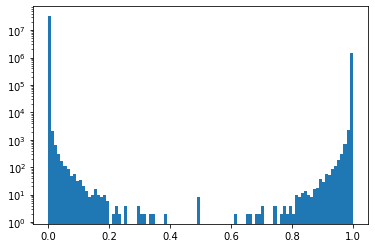

In [29]:
inv_dmats = 1. / (1e-2 + dmats)**2
inv_dmats /= inv_dmats.sum(axis=2, keepdims=True)
_ = plt.hist(inv_dmats.ravel(), bins=100, log=True)

In [30]:
X_play = train_reorient[play_cols].values[::22]
ss_play = StandardScaler()
X_play = ss_play.fit_transform(X_play)

In [31]:
del train

In [34]:
from keras import backend as K


class LayerNormalization(keras.layers.Layer):

    def __init__(self,
                 center=True,
                 scale=True,
                 epsilon=None,
                 gamma_initializer='ones',
                 beta_initializer='zeros',
                 gamma_regularizer=None,
                 beta_regularizer=None,
                 gamma_constraint=None,
                 beta_constraint=None,
                 **kwargs):
        """Layer normalization layer
                See: [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf)
        :param center: Add an offset parameter if it is True.
        :param scale: Add a scale parameter if it is True.
        :param epsilon: Epsilon for calculating variance.
        :param gamma_initializer: Initializer for the gamma weight.
        :param beta_initializer: Initializer for the beta weight.
        :param gamma_regularizer: Optional regularizer for the gamma weight.
        :param beta_regularizer: Optional regularizer for the beta weight.
        :param gamma_constraint: Optional constraint for the gamma weight.
        :param beta_constraint: Optional constraint for the beta weight.
        :param kwargs:
        """
        super(LayerNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.center = center
        self.scale = scale
        if epsilon is None:
            epsilon = K.epsilon() * K.epsilon()
        self.epsilon = epsilon
        self.gamma_initializer = keras.initializers.get(gamma_initializer)
        self.beta_initializer = keras.initializers.get(beta_initializer)
        self.gamma_regularizer = keras.regularizers.get(gamma_regularizer)
        self.beta_regularizer = keras.regularizers.get(beta_regularizer)
        self.gamma_constraint = keras.constraints.get(gamma_constraint)
        self.beta_constraint = keras.constraints.get(beta_constraint)
        self.gamma, self.beta = None, None

        
    def get_config(self):
        config = {
            'center': self.center,
            'scale': self.scale,
            'epsilon': self.epsilon,
            'gamma_initializer': keras.initializers.serialize(self.gamma_initializer),
            'beta_initializer': keras.initializers.serialize(self.beta_initializer),
            'gamma_regularizer': keras.regularizers.serialize(self.gamma_regularizer),
            'beta_regularizer': keras.regularizers.serialize(self.beta_regularizer),
            'gamma_constraint': keras.constraints.serialize(self.gamma_constraint),
            'beta_constraint': keras.constraints.serialize(self.beta_constraint),
        }
        base_config = super(LayerNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        shape = input_shape[-1:]
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape,
                initializer=self.gamma_initializer,
                regularizer=self.gamma_regularizer,
                constraint=self.gamma_constraint,
                name='gamma',
            )
        if self.center:
            self.beta = self.add_weight(
                shape=shape,
                initializer=self.beta_initializer,
                regularizer=self.beta_regularizer,
                constraint=self.beta_constraint,
                name='beta',
            )
        super(LayerNormalization, self).build(input_shape)
        
    def call(self, inputs, training=None):
        mean = K.mean(inputs, axis=-1, keepdims=True)
        variance = K.mean(K.square(inputs - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        outputs = (inputs - mean) / std
        if self.scale:
            outputs *= self.gamma
        if self.center:
            outputs += self.beta
        return outputs

In [35]:
y_mae = train_reorient['Yards'].values[::22]
y_mean = np.median(y_mae)
y_crps = np.zeros(shape=(y_mae.shape[0], 199))
for i,yard in enumerate(y_mae):
    y_crps[i, yard+99:] = 1
    
yardline = train_reorient['YardLine_std'].values[::22]

In [37]:
def crps(y_true, y_pred):
    stops = np.arange(-99, 100)
    unit_steps = stops >= y_true.reshape(-1, 1)
    crps = np.mean((y_pred - unit_steps)**2)
    return crps

In [38]:
baseline = np.histogram(y_mae, bins = range(-100, 100, 1))[0].cumsum()/len(y_mae)
crps(y_mae, baseline)

0.014500742984789266

In [39]:
def nondecreasing(x):
    X_ir = np.arange(199).astype('float64')
    ir = IsotonicRegression(0, 1)
    x = ir.fit_transform(X_ir, x.astype('float64'))        
    return x

In [40]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Add, Multiply, Dot
from keras.layers import Embedding, Permute, Reshape, GaussianNoise
from keras.layers.core import Dropout, Lambda, Dense, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, Conv1D
from keras.layers.pooling import GlobalMaxPooling1D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.merge import concatenate, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam, SGD, Nadam
from keras import backend as K

from keras.engine.topology import Layer
import tensorflow as tf


In [41]:
class ScaleLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(ScaleLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(ScaleLayer, self).build(input_shape) 

    def call(self, x):
        xx = K.arange(-99, 100, dtype=tf.float32)
        mu = y_mean + tf.reshape(x[:, 0], (-1, 1))
        sigma_minus = tf.identity(K.exp(0.5 * tf.reshape(x[:, 1], (-1, 1))), name="sigma")
        sigma_plus = tf.identity(K.exp(0.5 * tf.reshape(x[:, 2], (-1, 1))), name="sigma")
        xx = tf.subtract(xx, mu)
        pcf = tf.where(xx >= 0, tf.divide (xx, sigma_plus),  tf.divide (xx, sigma_minus))
        return pcf

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [42]:
def message_mult(n, e):
    res = Lambda(lambda c: K.batch_dot(c[0], c[1]), name="mul_1")([e, n])
    res = Lambda(lambda res: K.sum(res, axis=-1))(res)
    res = Lambda(lambda res: K.sum(res, axis=-1, keepdims=True))(res)
    return res

def rusher_dist_mult(dist, players):
    res = Lambda(lambda c: c[0] * c[1])([dist, players])
    return res
  
def dist_mult(dist, players):
    res = Lambda(lambda c: K.batch_dot(c[0], c[1]))([dist, players])
    return res
